# Analisis de calidad de suministro electrico
## Analisis y Visualizacion de datos

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#from IPython.display import Image
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [8]:
data_path = './data/SULGIPE_46_2018-12-31_M10_20190611-1750.gdb'
# Carguemos la tabla de consumidores de baja tension denominada UCBT
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')

In [9]:
col_sel = ['PAC', 'CONJ', 'MUN', 'BRR', 'CLAS_SUB', 'CNAE', 
 'FAS_CON', 'GRU_TEN', 'TEN_FORN', 'GRU_TAR', 'DAT_CON', 'CAR_INST',
 'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
 'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'ARE_LOC', 'SIT_ATIV',
 'FIC', 'DIC']

data = ucbt[col_sel]

### Calcule el consumo total anual de cada consumidor.

In [10]:
annual_totals = []
for index, row in data.iterrows():
    annual_total = row.ENE_01+row.ENE_02+ \
     row.ENE_03+row.ENE_04+row.ENE_05+ \
    row.ENE_06+row.ENE_07+row.ENE_08+ \
    row.ENE_09+row.ENE_10+row.ENE_11+ \
    row.ENE_02
    annual_totals.append(annual_total)

In [11]:
data['consumo_anual'] = annual_totals
data.sort_values(by=['consumo_anual']).head() #negative values!!!!

,PAC,CONJ,MUN,BRR,CLAS_SUB,CNAE,FAS_CON,GRU_TEN,TEN_FORN,GRU_TAR,...,ENE_08,ENE_09,ENE_10,ENE_11,ENE_12,ARE_LOC,SIT_ATIV,FIC,DIC,consumo_anual
133170,UC173274,15602,2802106,POV PORTO DO MATO,RE1,0,ABN,BT,22,B1,...,17.0,32.0,26.0,4.0,40.0,NU,AT,3.0,1.32,-2229.0
17070,UC76575,15601,2803005,ITABAIANINHA,RE1,0,AN,BT,22,B1,...,0.0,0.0,0.0,0.0,0.0,UB,AT,2.0,0.78,-1677.0
95427,UC2010,15602,2802106,SÃO JORGE,RE1,0,AN,BT,22,B1,...,44.0,34.0,0.0,0.0,0.0,UB,AT,5.0,5.10,-1411.0
45694,UC1349,15602,2802106,CENTRO,RE1,0,CN,BT,22,B1,...,0.0,0.0,0.0,0.0,0.0,UB,DS,3.0,0.92,-489.0
6467,UC19218,15602,2802106,POV ZECA DE LOIA,RE1,0,AN,BT,22,B1,...,0.0,3.0,1.0,3.0,0.0,NU,AT,7.0,11.12,-266.0


In [12]:
print("Consumo anual mean: ",data.consumo_anual.mean())#= 1392.671kWh,
print("Max: ",data.consumo_anual.max())#= 7825074.0
print("desvio estandar: ",data.consumo_anual.std())#= 27441.344 .

Consumo anual mean:  1392.6710505977783
Max:  7825074.0
desvio estandar:  27441.34403466776


### Cuando sea posible calcule la correlacion entre cada variable y la salida, y entre variables.

#### Numeric con numeric: coeficiente de correlacion o "R"

In [13]:
data_types = (data.dtypes == "float")
quant = []
for idx, value in data_types.items():
    if value == True:
        quant.append(idx)  
quant.remove('DIC')
quant.remove('FIC')
print(quant)# names of numeric variables 

['CAR_INST', 'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07', 'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'consumo_anual']


In [14]:
numerica = []
R = []
for i in quant:
    numeric = data[f"{i}"]
    r, stat = pearsonr(numeric.values,data.DIC.values)
    R.append(r)

DIC = ['DIC'] * len(quant)
    
df = pd.DataFrame({'entrada': quant,
                   'salida': DIC,
                 'R':R})
df

,entrada,salida,R
0,CAR_INST,DIC,-0.002368
1,ENE_01,DIC,-0.005270
2,ENE_02,DIC,-0.006265
3,ENE_03,DIC,-0.005916
4,ENE_04,DIC,-0.006691
5,ENE_05,DIC,-0.006445
6,ENE_06,DIC,-0.006904
7,ENE_07,DIC,-0.006604
8,ENE_08,DIC,-0.006556
9,ENE_09,DIC,-0.006170


#### Categorical con numeric (DIC): weighted variance

El siguiente codigo es del articulo [Shaked Zychlinski](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) publicado en Towards Data Science.

In [15]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


In [16]:
data_types = (data.dtypes == "object")
qual = []
for idx, value in data_types.items():
    if value == True:
        qual.append(idx)  
qual.append('CONJ')
print(qual)# names of categorical variables 

['PAC', 'MUN', 'BRR', 'CLAS_SUB', 'CNAE', 'FAS_CON', 'GRU_TEN', 'TEN_FORN', 'GRU_TAR', 'DAT_CON', 'ARE_LOC', 'SIT_ATIV', 'CONJ']


In [17]:
categorica = []
correlation = []
for i in qual:
    cat = data[f"{i}"]
    eta = correlation_ratio(cat.values,data.DIC.values)
    correlation.append(eta)

DIC = ['DIC'] * len(qual)

df = pd.DataFrame({'entrada': qual,
                   'salida' : DIC,
                 'correlation': correlation})
df

,entrada,salida,correlation
0,PAC,DIC,0.999495
1,MUN,DIC,0.301193
2,BRR,DIC,0.851085
3,CLAS_SUB,DIC,0.112568
4,CNAE,DIC,0.037508
5,FAS_CON,DIC,0.073200
6,GRU_TEN,DIC,0.000000
7,TEN_FORN,DIC,0.000000
8,GRU_TAR,DIC,0.100983
9,DAT_CON,DIC,0.372960


### Escoja una variable categorica y calcule las distribuciones condicionales para cada nivel de la misma.

#### Distribución condicional para DIC en GRU_TAR

In [18]:
data['DIC_CAT'] = pd.cut(data['DIC'], [-1,2,5,10], labels=['low', 'medium', 'high'])
cond_prob = pd.crosstab(data.GRU_TAR, data.DIC_CAT)
cond_prob 

DIC_CAT,low,medium,high
GRU_TAR,,,
B1,26499,33601,35930
B1BR,146,205,246
B2RU,510,994,1333
B2SP,0,1,1
B3,3561,3442,2953
B4A,18,11,12


**P(un cliente en GRU_TAR B1 ∣ tiene medium duracion de corte)**

In [19]:
def sum_list(items):
    sum_numbers = 0
    for x in items:
        sum_numbers += x
    return sum_numbers
print(sum_list(cond_prob.sum(axis=1)))

109463


In [20]:
print("Probabilidad que un cliente en GRU_TAR B1 tiene medium duracion de corte: ",int(cond_prob.sum(axis=1).B1)/int(sum_list(cond_prob.sum(axis=1))))

Probabilidad que un cliente en GRU_TAR B1 tiene medium duracion de corte:  0.877282734805368


### Como varia el servicio entre zonas urbanas y rurales?

Sacamos los valores ```0``` de```ARE_LOC``` porque no sabemos a que se refiere y cambian mucho el imagen resultado. 

In [21]:
target_0 = data.loc[data['ARE_LOC'] == 'NU']
target_1 = data.loc[data['ARE_LOC'] == "UB"]

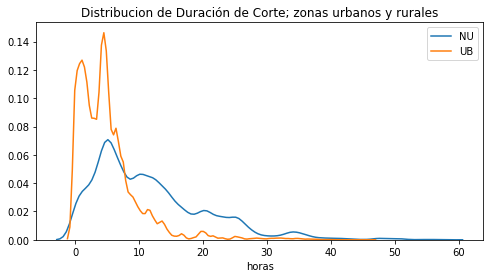

In [22]:
fig = plt.figure(figsize=(8,4))
plt.xlabel('horas')
plt.title('Distribucion de Duración de Corte; zonas urbanos y rurales')
ax = sns.distplot(target_0[['DIC']], label='NU', hist=False)
bx = sns.distplot(target_1[['DIC']], label='UB', hist=False)
ax.legend()

### Como varia el consumo entre zonas urbanas y rurales?

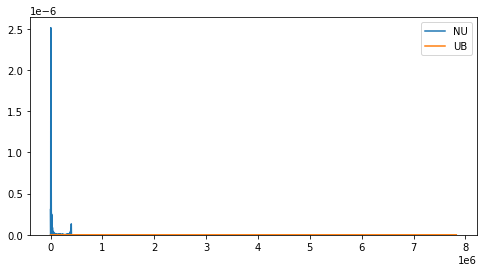

In [23]:
fig = plt.figure(figsize=(8,4))
#plt.xlabel('DIC (duración de corte en horas)')
#plt.title('Tabla de frequencia entre zonas urbanos y rurales y duración de corte (categorizado por bins)')
ax = sns.distplot(target_0[['consumo_anual']], label='NU', hist=False)
bx = sns.distplot(target_1[['consumo_anual']], label='UB', hist=False)
ax.legend()